Found 25146 images belonging to 26 classes.
Found 3958 images belonging to 26 classes.
Epoch 1/200
1571/1571 [==============================] - 278s 173ms/step - loss: 2.4313 - accuracy: 0.3252 - val_loss: 1.4101 - val_accuracy: 0.5868 - lr: 1.0000e-04
Epoch 2/200
1571/1571 [==============================] - 170s 108ms/step - loss: 1.5676 - accuracy: 0.5423 - val_loss: 1.2125 - val_accuracy: 0.6316 - lr: 1.0000e-04
Epoch 3/200
1571/1571 [==============================] - 170s 108ms/step - loss: 1.2802 - accuracy: 0.6250 - val_loss: 1.5533 - val_accuracy: 0.5630 - lr: 1.0000e-04
Epoch 4/200
1571/1571 [==============================] - 170s 108ms/step - loss: 1.1322 - accuracy: 0.6644 - val_loss: 0.9019 - val_accuracy: 0.7280 - lr: 1.0000e-04
Epoch 5/200
1571/1571 [==============================] - 171s 109ms/step - loss: 1.0112 - accuracy: 0.7003 - val_loss: 0.5621 - val_accuracy: 0.8277 - lr: 1.0000e-04
Epoch 6/200
1571/1571 [==============================] - 171s 109ms/step - loss: 0.

c:\Users\jobin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


248/248 [==============================] - 13s 52ms/step
Test Loss: 0.2454296499490738
Test Accuracy: 0.92091965675354
Computed Accuracy: 0.06467913087417888
Confusion Matrix:
[[21 21 30 23  5  6  6  4  1  3 19 17 15 14  2 34  9  9 10 11  9  9 10  8
   6 10]
 [23 44 39 36  2  6  1  2  4  4 19 22 23 17  3 45 11  7 10  6  9 14  8  7
   6 12]
 [28 28 38 29  7  4  5  2  6  5 25 24 20 17  2 26  9 13  9 11  9 10  6  9
   8 10]
 [32 40 33 29  1  3  3  4  0  8 16 45 18  9  3 26  7  8  4 11  5  4  5  9
  11 13]
 [ 4  3  3  9  1  1  0  0  1  0  1  9  0  1  0  5  2  1  1  1  0  1  1  1
   2  0]
 [ 6  4  5  1  0  4  1  1  0  1  3  9  1  2  0  3  1  3  0  1  3  0  0  1
   2  2]
 [ 6  1  3  5  1  0  1  1  0  1  3  4  1  2  0  4  0  2  1  1  4  1  1  0
   0  3]
 [ 4  3  3  4  1  0  1  0  1  1  6  3  1  5  1  2  1  2  2  2  2  0  0  0
   1  0]
 [ 2  6  7  2  0  1  0  0  0  0  5  3  3  2  0  2  1  0  3  1  1  1  2  1
   2  1]
 [ 3  6  1  3  1  1  2  1  3  1  2  7  4  2  0  2  1  2  0  0  0  0  1  0
   

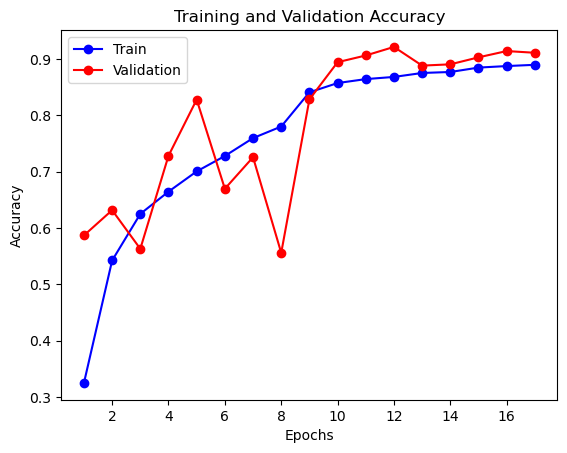

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Defining the paths to the dataset
train_data = 'Dataset/train'  # Updated path
test_data = 'Dataset/val'  # Updated path

# Initializing the CNN
np.random.seed(1337)

# Defining the number of classes and other parameters
num_classes = 26
input_shape = (32, 32, 3)
batch_size = 16
epochs = 200

# Normalization
train_data_gen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess and augment the training images
train_generator = train_data_gen.flow_from_directory(
    train_data,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and preprocess the testing dataset
test_generator = test_data_gen.flow_from_directory(
    test_data,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

# Define the custom ResNet-like block
def resnet_block(x, filters, kernel_size=3, stride=1):
    # Shortcut
    shortcut = x

    # Adjust the shortcut dimensions if needed
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
    
    # First convolution layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Add the shortcut to the main path
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

input_tensor = tf.keras.Input(shape=input_shape)
# Build the custom ResNet-50-like model
model = Sequential()

# Initial convolution layer
x = Conv2D(64, kernel_size=7, strides=2, padding='same', input_shape=input_shape)(input_tensor)
x = BatchNormalization()(x)
x = ReLU()(x)

# Residual blocks
x = resnet_block(x, filters=64)
x = resnet_block(x, filters=64)
x = resnet_block(x, filters=128, stride=2)
x = resnet_block(x, filters=128)
x = resnet_block(x, filters=256, stride=2)
x = resnet_block(x, filters=256)
x = resnet_block(x, filters=128, stride=2)
x = resnet_block(x, filters=128)
x = resnet_block(x, filters=512, stride=2)
x = resnet_block(x, filters=512)

# Global average pooling and fully connected layer
x = GlobalAveragePooling2D()(x)
x = Dense(units=64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_tensor = Dense(units=num_classes, activation='softmax')(x)

# Set the model's output
model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the classifier
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Add EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8)

# Train the classifier
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=test_generator.samples // batch_size,
                    callbacks=[early_stopping, reduce_lr]
                    )

# Save the classifier
model.save('classifier.h5')

# Evaluate the classifier on the testing dataset
test_loss, test_accuracy = model.evaluate(test_generator)

# Compute the predicted labels for the testing dataset
predicted_labels = model.predict(test_generator)
predicted_classes = np.argmax(predicted_labels, axis=1)

# Get the true labels for the testing dataset
true_labels = test_generator.classes

# Compute the accuracy
accuracy = np.sum(predicted_classes == true_labels) / len(true_labels)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print('Computed Accuracy:', accuracy)

# Compute confusion matrix
confusion = confusion_matrix(true_labels, predicted_classes)

# Print confusion matrix in a good format
print("Confusion Matrix:")
print(confusion)

# Compute and print accuracy per class
class_accuracy = confusion.diagonal() / confusion.sum(axis=1)
class_names = list(test_generator.class_indices.keys())

print("\nAccuracy per class:")
for class_name, acc in zip(class_names, class_accuracy):
    print(f"{class_name}: {acc:.4f}")

# Plot training and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo-', label='Train')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [5]:
output_tensor = Dense(units=num_classes, activation='softmax')(x)
print(output_tensor)

KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='dense_6/Softmax:0', description="created by layer 'dense_6'")
